# DDoS Attacks Detection and Characterization


Import pyton libraries

In [ ]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime 

In [11]:
df = pd.read_csv('ddos_dataset.csv')

df_copy = df.copy()

/tmp/ipykernel_15327/3984028547.py:1: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ddos_dataset.csv')


## Section 1 – Data exploration and pre-processing

In [ ]:
#Fix column names
df.columns = [col.strip().replace(" ", "") for col in df.columns] 

#Drop unnecessary columns 
df.drop(columns=['FlowID'],inplace=True)
df.drop(columns=['Unnamed:0'],inplace=True)

#Fix similarHTTP column values
df['SimillarHTTP'] = df['SimillarHTTP'].apply(lambda x : 1 if x != 0 else 0)
print(df['SimillarHTTP'].value_counts())



SimillarHTTP
1    40960
0    23279
Name: count, dtype: int64


In [9]:
#Int this section we remove columns that have the same value in every row (no variability), since they are meanningless for the analysis or modeling
#We can notice that 12 columns have just one unique value, so we went from 88 columns to 76 columns 

#unique values per column
uniqueVpc = df.apply(lambda col: col.unique())

#Columns with just one unique value
cwov = uniqueVpc[uniqueVpc.apply(len) == 1].index

print("Columns meaningless beacuse they have the same value on all rows:")
print(cwov)

df = df.drop(columns=cwov)

df.info()

Columns meaningless beacuse they have the same value on all rows:
Index(['BwdPSHFlags', 'FwdURGFlags', 'BwdURGFlags', 'FINFlagCount',
       'PSHFlagCount', 'ECEFlagCount', 'FwdAvgBytes/Bulk',
       'FwdAvgPackets/Bulk', 'FwdAvgBulkRate', 'BwdAvgBytes/Bulk',
       'BwdAvgPackets/Bulk', 'BwdAvgBulkRate'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64239 entries, 0 to 64238
Data columns (total 76 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed:0                64239 non-null  int64  
 1   FlowID                   64239 non-null  object 
 2   SourceIP                 64239 non-null  object 
 3   SourcePort               64239 non-null  int64  
 4   DestinationIP            64239 non-null  object 
 5   DestinationPort          64239 non-null  int64  
 6   Protocol                 64239 non-null  int64  
 7   Timestamp                64239 non-null  object 
 8   FlowDuration    

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64239 entries, 0 to 64238
Data columns (total 88 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed:0                64239 non-null  int64  
 1   FlowID                   64239 non-null  object 
 2   SourceIP                 64239 non-null  object 
 3   SourcePort               64239 non-null  int64  
 4   DestinationIP            64239 non-null  object 
 5   DestinationPort          64239 non-null  int64  
 6   Protocol                 64239 non-null  int64  
 7   Timestamp                64239 non-null  object 
 8   FlowDuration             64239 non-null  int64  
 9   TotalFwdPackets          64239 non-null  int64  
 10  TotalBackwardPackets     64239 non-null  int64  
 11  TotalLengthofFwdPackets  64239 non-null  float64
 12  TotalLengthofBwdPackets  64239 non-null  float64
 13  FwdPacketLengthMax       64239 non-null  float64
 14  FwdPacketLengthMin    

In [6]:
df.describe()

,Unnamed:0,SourcePort,DestinationPort,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Inbound
count,64239.000000,64239.000000,64239.000000,64239.000000,6.423900e+04,64239.000000,64239.000000,64239.000000,6.423900e+04,64239.000000,...,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,64239.000000
mean,32637.819876,25267.368608,30715.252884,14.362864,5.150614e+06,18.814848,1.304036,6699.521630,2.153348e+03,613.992948,...,-4.167229e+07,9.026629e+03,4.878774e+03,1.687791e+04,6.204895e+03,1.155553e+06,2.613584e+05,1.555321e+06,8.908522e+05,0.919566
std,19008.473731,24710.413442,20347.990914,4.706001,2.249713e+07,462.305336,25.199720,20510.320389,9.087201e+04,585.691655,...,2.062767e+08,2.045563e+05,1.424082e+05,3.828583e+05,1.667756e+05,5.341380e+06,1.574889e+06,6.993415e+06,4.571276e+06,0.271966
min,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,...,-1.062719e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,16209.500000,779.000000,12435.500000,17.000000,1.000000e+00,2.000000,0.000000,123.000000,0.000000e+00,53.000000,...,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
50%,32477.000000,29661.000000,30797.000000,17.000000,2.000000e+00,2.000000,0.000000,1050.000000,0.000000e+00,393.000000,...,1.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
75%,48726.500000,48510.500000,49041.500000,17.000000,2.087700e+04,2.000000,0.000000,2944.000000,0.000000e+00,1464.000000,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
max,65999.000000,65518.000000,65535.000000,17.000000,1.200000e+08,85894.000000,1862.000000,176000.000000,8.829488e+06,3564.000000,...,1.480000e+03,1.678654e+07,2.853681e+07,6.783473e+07,8.349846e+06,1.147455e+08,5.275036e+07,1.147455e+08,1.147455e+08,1.000000


### BASIC TRAFFIC STATISTICS

In [8]:
n_src_ip = df["SourceIP"].nunique()
n_dst_ip = df["DestinationIP"].nunique()

print(f"Number of unique source IPs: {n_src_ip}")
print(f"Number of unique destination IPs: {n_dst_ip}")


Number of unique source IPs: 216
Number of unique destination IPs: 245


### CLASS DISTRIBUTION

{'ddos_dns': 5369, 'benign': 5658, 'ddos_ldap': 5928, 'ddos_mssql': 5911, 'ddos_netbios': 5830, 'ddos_ntp': 986, 'ddos_snmp': 5984, 'ddos_ssdp': 5970, 'ddos_udp': 5876, 'ddos_syn': 5480, 'ddos_tftp': 5261, 'ddos_udp_lag': 5986}


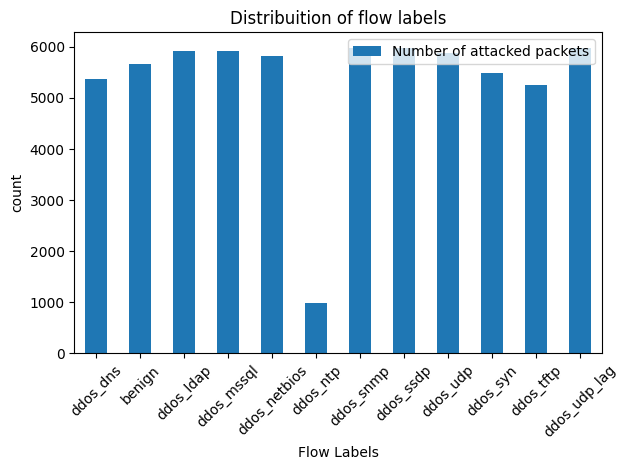

In [9]:
labels = df["label"].unique()

# n_benign = df[df["label"] == 'benign'].shape[0] 
# print(f"Number of benign packets: {n_benign}")
# n_benign_flows = df[df["label"] == 'benign'].groupby("FlowID").count().shape[0]
# print(f"Number of benign flows: {n_benign_flows}")

n_attack_per_label = {}
for label in labels:
    n_attack_per_label[label] = df[df["label"] == label].shape[0]

print(n_attack_per_label)

plot_df_n_labels = pd.DataFrame({
    'Number of attacked packets': n_attack_per_label,
})


plot_df_n_labels.plot(kind='bar')
plt.title('Distribuition of flow labels')
plt.xlabel('Flow Labels')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Categorial features encoding

In [ ]:
#Funzione per convertire IP in intero, qui convertiamo i source ip
def ip_to_int(ip):
    try:
        # Funziona sia per IPv4 che per IPv6
        return int(ipaddress.ip_address(ip))
    except:
        # Se c'è un errore (es. valore nullo o stringa errata), ritorna None o -1
        return None

#Applicare la funzione alla colonna 'Src IP'
df['SourceIpInt'] = df['SourceIP'].apply(ip_to_int)
df['DestinationIPInt'] = df['DestinationIP'].apply(ip_to_int)

print(df[['SourceIP', 'SourceIpInt']].head())
print(df[['DestinationIP', 'DestinationIPInt']].head())

df.info()
#si creeranno due colonne nuove con gli IP convertiti in interi

#Convert 'Timestamp' to seconds since the first timestamp
reference_date = min(df['Timestamp'])
df['Timestamp'] = (df['Timestamp']-reference_date).dt.total_seconds()

       SourceIP SourceIpInt
0    172.16.0.5        None
1  192.168.50.1        None
2    172.16.0.5        None
3    172.16.0.5        None
4    172.16.0.5        None
  DestinationIP DestinationIPInt
0  192.168.50.1             None
1    172.16.0.5             None
2  192.168.50.1             None
3  192.168.50.1             None
4  192.168.50.1             None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64239 entries, 0 to 64238
Data columns (total 78 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed:0                64239 non-null  int64  
 1   FlowID                   64239 non-null  object 
 2   SourceIP                 64239 non-null  object 
 3   SourcePort               64239 non-null  int64  
 4   DestinationIP            64239 non-null  object 
 5   DestinationPort          64239 non-null  int64  
 6   Protocol                 64239 non-null  int64  
 7   Timestamp                64239 non

TypeError: unsupported operand type(s) for -: 'str' and 'str'